<a href="https://colab.research.google.com/github/fjpcediel87/DeepLearning--Learning/blob/main/Simple_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.34MB/s]


In [3]:
len(dataset)

60000

image.shape: torch.Size([1, 28, 28])
Label: 5


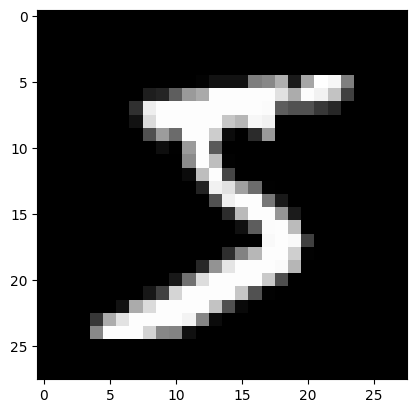

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import random_split
val_size =10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


images.shape: torch.Size([128, 1, 28, 28])


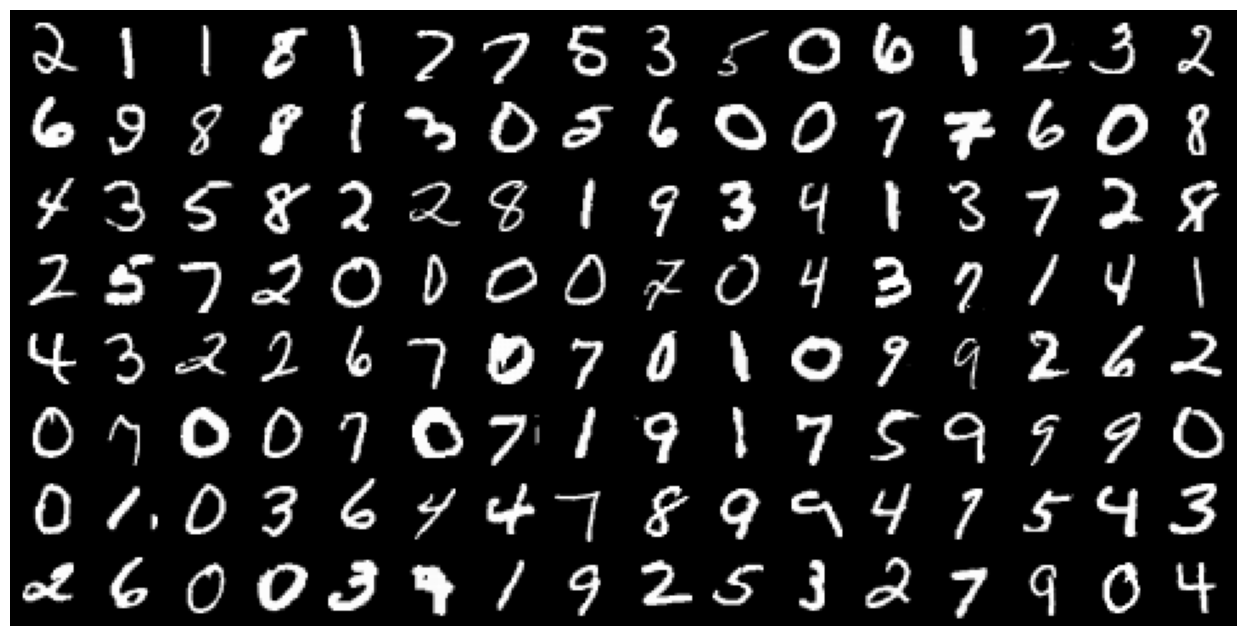

In [7]:
from torchvision.utils import make_grid
for images,_ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
  break

#Hidden layers, Activation Functions and Non-linearity

A NN with two layers will be created: A hidden layer and a output layer. There will be an activation function between the two layers.

In [8]:
for images, labels in train_loader:
  print('images.shape:', images.shape)
  inputs = images.reshape(-1,28*28)
  print('inputs.shape:', inputs.shape)
  break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, a nn.Linear object will be created, which will serve as the hidden layer. The size of its output will be 32 elements.

![](https://media.licdn.com/dms/image/v2/C5612AQEtIPalWZIrLQ/article-inline_image-shrink_1500_2232/article-inline_image-shrink_1500_2232/0/1629333609383?e=1762387200&v=beta&t=7y3raVWa2rBW44am-9xo9WKwJPKjf8Qsei9lDQXKZF4)

In [9]:
input_size = inputs.shape[-1]
hidden_size = 32

In [10]:
import torch.nn.functional as F
import torch.nn as nn
layer1 = nn.Linear(input_size, hidden_size)
layer1

Linear(in_features=784, out_features=32, bias=True)

In [11]:
inputs.shape

torch.Size([128, 784])

In [12]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The above function is  explained by the Matrix operation below. Please note both torches are 128 x 32

In [13]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias #Matrix operation
print('layer1_outputs_direct.shape:', layer1_outputs_direct.shape)

layer1_outputs_direct.shape: torch.Size([128, 32])


In [14]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3) #This function compares both results with a tolerance of 1e-3

True

Next, the Rectified Linear Unit (ReLU) function will be used as the activation function for the outputs. This formula is relu(x) = max(0,x), it replaces the negative values in a given tensor with the value 0.

![](https://media.licdn.com/dms/image/v2/C5612AQHr87wQF3iWbw/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1629340615667?e=1762387200&v=beta&t=gwbUGryFGJ7CUJ3p2f9M6buWtWq-zXf8L3sbHREq14k)

https://www.linkedin.com/pulse/activation-functions-101-sigmoid-tanh-relu-softmax-ben-hammouda/



In [15]:
F.relu(torch.tensor([[1,-1,0],[-0.1, .2, 3]])) #Example

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [16]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())
#

min(layer1_outputs): -0.8468635082244873
min(relu_outputs): 0.0


Relu activation function will work only with those outputs that were positive and the relationship between the layer1 outputs and Relu outputs are no longer linear.

Now, an output layer will be created to convert the relu vector into  vectors of length 10 since we have 10 target labels

In [17]:
output_size =10
layer2 = nn.Linear(hidden_size, output_size)

In [18]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


Now we can compute loss function with `F.cross_entropy`to adjust the weights of `layer1` and `layer2` using gradient descent.

In [19]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3265, grad_fn=<NllLossBackward0>)

We can make the operation directly as follows:

In [20]:
outputs= (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias
torch.allclose(outputs, layer2_outputs, 2e-3)

#print('outputs.shape:', outputs.shape)

True

What if I were not used the ReLU activation function? Well, If I had not done that, there would not have made any sense to create different layers. The ReLU layers modifies the linear relationship between the layers.

In [21]:
# Imagine a fictional layer without activation function
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias
combined_layer= nn.Linear(input_size, output_size)
combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer2.weight @ layer1.bias + layer2.bias
outputs3 = inputs@combined_layer.weight.t() + combined_layer.bias
torch.allclose(outputs2, outputs3, 1e-3)

True

# Model

We are now ready to define our model.

In [49]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
      # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        #Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        #Apply activation function
        out = F.relu(out)
        #Get predictions using output layer
        out = self.linear2(out)
        return out



    def training_step(self, batch):
        """ Returns the loss for a  batch of training data"""
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

#model = MnistModel(input_size, hidden_size, output_size)

In [50]:
    def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [23]:
input_size = 784
hidden_size = 32
num_classes = 10

In [24]:
model = MnistModel(input_size, hidden_size,  num_classes)

In [25]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [26]:
for images, labels in train_loader:
    outputs = model(images)

    break
loss = F.cross_entropy(outputs, labels)
print('Loss:', loss.item())
print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.324195384979248
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1883,  0.2312,  0.0982, -0.0598, -0.1829, -0.0263, -0.0889,  0.1262,
          0.0458, -0.0333],
        [ 0.1647,  0.1437,  0.0684, -0.0837, -0.1184,  0.0167, -0.0728,  0.0359,
          0.1254, -0.0226]])


## Using a GPU

In [27]:
torch.cuda.is_available()

True

To ensure using GPU on Google Colab, go to RAM/disk right-top corner and select `Change runtime type` to `Python 3 T4 GPU`.

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [31]:
device

device(type='cuda')

In [32]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [34]:
for images, labels in train_loader:
    print(images.shape)
    print(image.device)
    images= to_device(images, device)
    print(images.device)
    break


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([128, 1, 28, 28])
cpu
cuda:0


Since the above step is an iteration, we should create the function below:

In [35]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [42]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [43]:
for xb, yb in val_loader:
  print('xb.device:', xb.device)
  print('yb:', yb)
  break

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


xb.device: cuda:0
yb: tensor([1, 1, 3, 2, 5, 7, 0, 1, 1, 6, 4, 3, 2, 4, 8, 3, 2, 3, 7, 2, 0, 2, 8, 5,
        6, 4, 9, 4, 1, 8, 2, 4, 5, 4, 3, 8, 1, 2, 8, 3, 8, 5, 8, 9, 7, 6, 2, 0,
        4, 7, 1, 4, 0, 9, 7, 9, 3, 4, 5, 3, 5, 1, 2, 4, 9, 4, 7, 1, 5, 0, 6, 7,
        1, 9, 9, 2, 9, 5, 6, 1, 1, 3, 6, 9, 3, 8, 8, 7, 4, 7, 1, 9, 2, 8, 0, 6,
        7, 5, 7, 4, 6, 8, 7, 8, 0, 7, 4, 3, 5, 8, 0, 2, 5, 2, 9, 0, 6, 0, 8, 7,
        5, 3, 4, 0, 5, 2, 1, 4, 5, 0, 1, 4, 7, 9, 5, 7, 3, 1, 9, 3, 2, 0, 5, 6,
        3, 0, 7, 5, 6, 0, 3, 8, 1, 4, 9, 8, 9, 6, 1, 0, 8, 6, 4, 3, 3, 2, 7, 5,
        7, 2, 7, 8, 6, 2, 6, 8, 2, 2, 8, 5, 9, 7, 8, 7, 7, 7, 0, 9, 5, 2, 6, 7,
        9, 7, 5, 6, 7, 3, 8, 9, 7, 5, 7, 1, 7, 2, 5, 6, 6, 8, 6, 4, 8, 7, 0, 3,
        6, 6, 4, 1, 4, 1, 4, 0, 6, 3, 3, 2, 1, 8, 3, 2, 2, 1, 1, 5, 4, 1, 1, 7,
        4, 4, 4, 8, 7, 7, 4, 9, 8, 0, 4, 7, 4, 2, 2, 1], device='cuda:0')


# Training the Model

In [44]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):

        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [45]:
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [52]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.30583119392395, 'val_acc': 0.0771484375}]

In [53]:
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [0], val_loss: 0.2353, val_acc: 0.9337
Epoch [1], val_loss: 0.1786, val_acc: 0.9470
Epoch [2], val_loss: 0.1587, val_acc: 0.9511
Epoch [3], val_loss: 0.1528, val_acc: 0.9534
Epoch [4], val_loss: 0.1432, val_acc: 0.9570


In [54]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1249, val_acc: 0.9630
Epoch [1], val_loss: 0.1237, val_acc: 0.9637
Epoch [2], val_loss: 0.1215, val_acc: 0.9638
Epoch [3], val_loss: 0.1208, val_acc: 0.9631
Epoch [4], val_loss: 0.1212, val_acc: 0.9634


In [55]:
import matplotlib.pyplot as plt

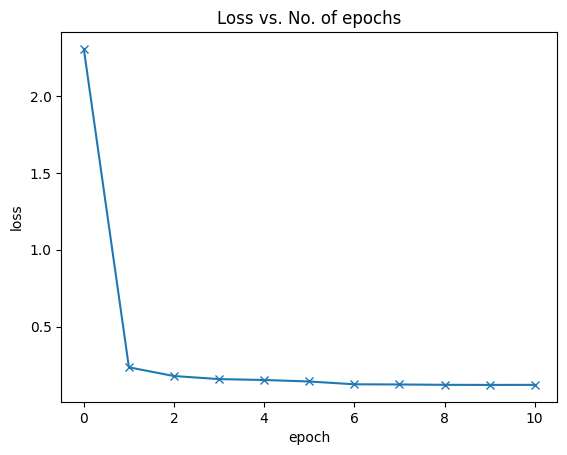

In [57]:
# Replace these values with your results
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

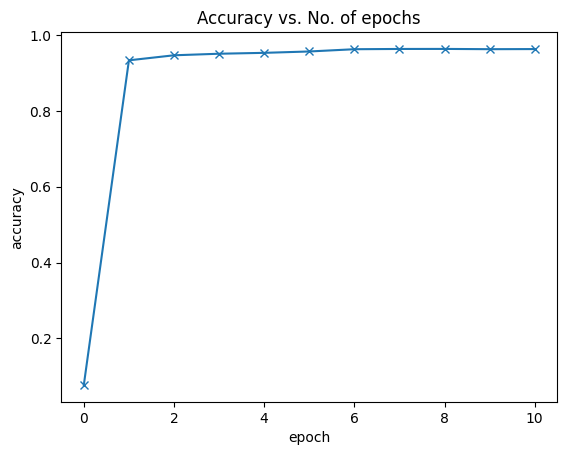

In [58]:
# Replace these values with your results
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# Testing with individual images

In [62]:
# Define test dataset
import torchvision.transforms as transforms
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=transforms.ToTensor())

In [63]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0),device) #it must run on the same device (Cuda)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


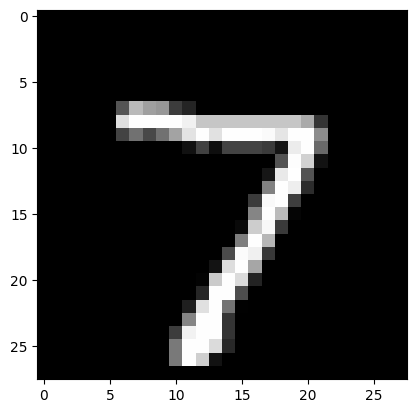

In [64]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


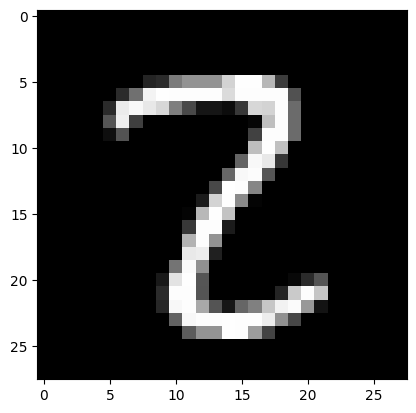

In [65]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


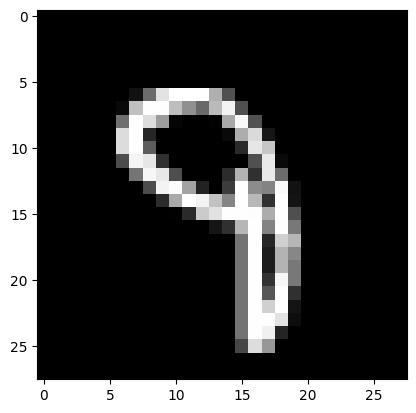

In [66]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [67]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256),device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10319981724023819, 'val_acc': 0.968554675579071}